# Imports and settings

In [12]:
#test if current transfer training works
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Flatten, Bidirectional, Input, RepeatVector, Conv1D, MaxPooling1D, LeakyReLU
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from google.colab import drive
drive.mount('/content/drive')

#from numpy.random import seed
#seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#in frames
SEQ_LEN = 100
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 2000
LOSS =  tf.keras.losses.mse#tf.keras.losses.logcosh
LOSS_NAME = "MSE"
OPT =  tf.keras.optimizers.Adam(lr=LEARNING_RATE, decay=1e-10)

# Preprocessing functions

In [0]:
max_vals = [600, 1, 18, 500]
min_vals = [170, 0, -10, 0]


def min_max_scale(_df):
    #x1 = (x - min_x) / (max_x - min_x)
    for col, max_val, min_val in zip(_df.columns, max_vals, min_vals):
        _df[col] = (_df[col] - min_val) / (max_val - min_val)

    _df.dropna(inplace=True)

    return _df

def build_seq(_df):
    out_df = _df.copy()

    out_df = out_df.drop(["birdJump", "birdVelocity", "pipeY"], axis=1)#drops all the non x and y columns

    sequential_data = []
    for i in range(len(_df.values) - (SEQ_LEN + SEQ_LEN)):

        prev_end = i+SEQ_LEN;

        _inp = _df.values[i:prev_end]
        _out = out_df.values[prev_end:prev_end+SEQ_LEN]
        
        sequential_data.append([np.array(_inp), np.array(_out)])

    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)
  
  
def load_and_split_runs(train_runs, test_run):
    train_input = np.empty((0, SEQ_LEN, 4))
    train_output = np.empty((0, SEQ_LEN, 1))
    
    
    for train_run in train_runs:
      _df = pd.read_csv("drive/My Drive/Data Sets/"+train_run+".csv")
      _df = min_max_scale(_df)
      _input, _output = build_seq(_df)
      
      
      train_input = np.concatenate((train_input, _input))
      train_output = np.concatenate((train_output, _output))

    test_df = pd.read_csv("drive/My Drive/Data Sets/"+test_run+".csv")
    test_df = min_max_scale(test_df)
    test_input, test_output = build_seq(test_df)
    
    #shuffle
    train_input, train_output = shuffle(train_input, train_output)
    test_input, test_output = shuffle(test_input, test_output)
    
    
    return train_input, test_input, train_output, test_output

# load and preprocess data

In [0]:
train_runs = ["flappyBird (2)",
             "flappyBird (3)",
             "flappyBird (4)",
             "flappyBird (5)",
             "flappyBird (6)",
             "flappyBird (7)",
             "flappyBird (8)",
             "flappyBird (9)",
             "flappyBird (10)",
             "flappyBird (11)",
             "flappyBird (12)",
             "flappyBird (13)",
             "flappyBird (14)",
             "flappyBird (15)",
             "flappyBird (16)",
             "flappyBird (17)",
             "flappyBird (18)",
             "flappyBird (19)",
             "flappyBird (20)",
             ]

train_input, test_input, train_output, test_output = load_and_split_runs(train_runs, "flappyBird")

# Train model

In [0]:
def plot_prediction(test_input, test_output, pred):
  x_in_seq_vals = np.linspace(start=0, stop=SEQ_LEN, num=SEQ_LEN)
  x_out_seq_vals = np.linspace(start=SEQ_LEN, stop=2*SEQ_LEN, num=SEQ_LEN)

  y_inp = []
  y_out = []
  y_pred = []


  for i in range(SEQ_LEN):
      y_inp.append(test_input[0][i][0])
      y_out.append(test_output[0][i][0])
      y_pred.append(pred[0][i][0])

  plt.scatter(x_in_seq_vals, y_inp, color="red", label="input")
  plt.scatter(x_out_seq_vals, y_out, color="blue", label="output")
  plt.scatter(x_out_seq_vals, y_pred, color="green", label="output")

  #plt.scatter(x_vals, main_df["birdY"], color="green")
  #plt.scatter(x_vals, main_df["pipeY"], color="black")

  plt.show()

In [0]:
def lstmModel():
    inputs = Input(shape=(train_input.shape[1:]))

    lstm_1 = LSTM(256, return_sequences=True)(inputs)
    lstm_1 = BatchNormalization()(lstm_1)
    lstm_1 = Dropout(0.5)(lstm_1)

    lstm_2 = LSTM(256, return_sequences=True)(lstm_1)
    lstm_2 = BatchNormalization()(lstm_2)
    lstm_2 = Dropout(0.5)(lstm_2)
    
    lstm_3 = LSTM(256, return_sequences=True)(lstm_2)
    lstm_3 = BatchNormalization()(lstm_3)
    lstm_3 = Dropout(0.5)(lstm_3)
   
    lstm_4 = LSTM(128, return_sequences=True)(lstm_3)

    outputs = Dense(1, activation="linear")(lstm_4)

    return Model(inputs=inputs, outputs=outputs)

def seq2seqModel():
    inputs = Input(shape=(train_input.shape[1:]))

    lstm_1 = LSTM(256, return_sequences=True)(inputs)
    lstm_1 = LSTM(256, return_sequences=False)(lstm_1)

    repeat_vec = RepeatVector(SEQ_LEN)(lstm_1)

    lstm_2 = LSTM(256, return_sequences=True)(repeat_vec)
    lstm_2 = LSTM(256, return_sequences=True)(lstm_2)
    
    dense_1 = Dense(128, activation="relu")(lstm_2)
    
    outputs = Dense(1, activation='linear')(dense_1)
    
    return Model(inputs=inputs, outputs=outputs) 

Train on 21463 samples, validate on 1248 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
21463/21463 [==============================] - 52s 2ms/sample - loss: 0.1893 - mean_squared_error: 0.1893 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 2/100
21463/21463 [==============================] - 62s 3ms/sample - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 3/100
21463/21463 [==============================] - 41s 2ms/sample - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 4/100
21463/21463 [==============================] - 42s 2ms/sample - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 5/100
21463/21463 [==============================] - 41s 2ms/sample - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 6

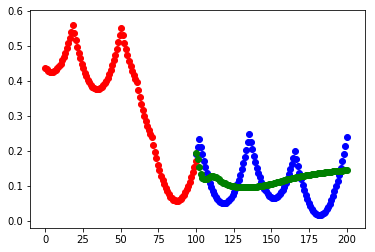

In [18]:
model = lstmModel()

model.compile(loss=LOSS, 
                  optimizer=OPT,
                  metrics=['mse']) 

# Train model
history = model.fit(
    train_input, train_output,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_input, test_output)
)

pred = model.predict(np.array([test_input[0]]))

plot_prediction(test_input, test_output, pred)

model.save_weights("model_1.h5")

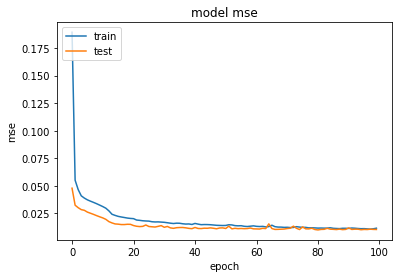

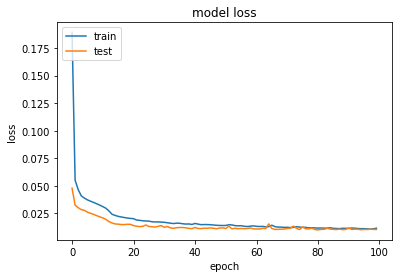

In [19]:
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save model

In [0]:
from google.colab import files

model.save('keras.h5')
files.download('keras.h5')
#!pip install "tensorflow>=1.7.0"
#!pip install tensorflowjs

#!mkdir model
#tfjs.converters.save_keras_model(model, "./model")
#!tensorflowjs_converter --input_format keras keras.h5 model/
#!zip -r model.zip model 

#files.download('model.zip')